# AAII Transformer Tutorial
### By David Reiman (github.com/davidreiman)

#### Note: you should use a GPU runtime while running this notebook. To do so, select `Runtime` -> `Change runtime type` and select `GPU` under `Hardware accelerator`. You should then be assigned a GPU. You can check this via the `!nvidia-smi` command.

In [0]:
!nvidia-smi

Fri Nov 22 01:55:08 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.50       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# Imports

In [0]:
%matplotlib inline
import os
import sys
import glob
import pickle
import zipfile
import datetime
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.utils as U
import torch.nn.functional as F
import numpy as np
import seaborn as sns
import collections as col
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from collections import Counter, OrderedDict

In [0]:
sns.set()
np.random.seed(1)
torch.manual_seed(1)
plt.rcParams['figure.figsize'] = (16, 8)

# Prepare data

### Download enwik8

enwik8 is a character-level dataset comprising the first $10^9$ bytes of the English Wikipedia.

In [0]:
!wget --continue http://mattmahoney.net/dc/enwik8.zip

--2019-11-21 03:14:11--  http://mattmahoney.net/dc/enwik8.zip
Resolving mattmahoney.net (mattmahoney.net)... 67.195.197.75
Connecting to mattmahoney.net (mattmahoney.net)|67.195.197.75|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 36445475 (35M) [application/zip]
Saving to: ‘enwik8.zip’

enwik8.zip          100%[===================>]  34.76M   336KB/s    in 1m 48s  

2019-11-21 03:16:00 (329 KB/s) - ‘enwik8.zip’ saved [36445475/36445475]



### Process enwik8 (credit: Salesforce)

This will turn all unique characters in enwik8 to their UTF-8 encoding (an 8-bit integer).

In [0]:
if os.path.exists('train.txt'):
    print('Tokenized enwik8 already exists - skipping processing')
    sys.exit()

data = zipfile.ZipFile('enwik8.zip').read('enwik8')

print('Length of enwik8: {}'.format(len(data)))

num_test_chars = 5000000

train_data = data[: -2 * num_test_chars]
valid_data = data[-2 * num_test_chars: -num_test_chars]
test_data = data[-num_test_chars:]

for fn, part in [('train.txt', train_data), ('valid.txt', valid_data), ('test.txt', test_data)]:
    print('{} will have {} bytes'.format(fn, len(part)))
    print('- Tokenizing...')
    part_str = ' '.join([str(c) if c != ord('\n') else '\n' for c in part])
    print('- Writing...')
    f = open(fn, 'w').write(part_str)
    f = open(fn + '.raw', 'wb').write(part)

# Utils

### Dataset iterator (credit: Zhilin Yang [Transformer-XL])

In [0]:
class Vocab(object):
    def __init__(self, special=[], min_freq=0, max_size=None, lower_case=True,
                 delimiter=None, vocab_file=None):
        self.counter = Counter()
        self.special = special
        self.min_freq = min_freq
        self.max_size = max_size
        self.lower_case = lower_case
        self.delimiter = delimiter
        self.vocab_file = vocab_file

    def tokenize(self, line, add_eos=False, add_double_eos=False):
        line = line.strip()
        # convert to lower case
        if self.lower_case:
            line = line.lower()

        # empty delimiter '' will evaluate False
        if self.delimiter == '':
            symbols = line
        else:
            symbols = line.split(self.delimiter)

        if add_double_eos: # lm1b
            return ['<S>'] + symbols + ['<S>']
        elif add_eos:
            return symbols + ['<eos>']
        else:
            return symbols

    def count_file(self, path, verbose=False, add_eos=False):
        if verbose: print('counting file {} ...'.format(path))
        assert os.path.exists(path)

        sents = []
        with open(path, 'r', encoding='utf-8') as f:
            for idx, line in enumerate(f):
                if verbose and idx > 0 and idx % 500000 == 0:
                    print('    line {}'.format(idx))
                symbols = self.tokenize(line, add_eos=add_eos)
                self.counter.update(symbols)
                sents.append(symbols)

        return sents

    def count_sents(self, sents, verbose=False):
        """
            sents : a list of sentences, each a list of tokenized symbols
        """
        if verbose: print('counting {} sents ...'.format(len(sents)))
        for idx, symbols in enumerate(sents):
            if verbose and idx > 0 and idx % 500000 == 0:
                print('    line {}'.format(idx))
            self.counter.update(symbols)

    def _build_from_file(self, vocab_file):
        self.idx2sym = []
        self.sym2idx = OrderedDict()

        with open(vocab_file, 'r', encoding='utf-8') as f:
            for line in f:
                symb = line.strip().split()[0]
                self.add_symbol(symb)
        self.unk_idx = self.sym2idx['<UNK>']

    def build_vocab(self):
        if self.vocab_file:
            print('building vocab from {}'.format(self.vocab_file))
            self._build_from_file(self.vocab_file)
            print('final vocab size {}'.format(len(self)))
        else:
            print('building vocab with min_freq={}, max_size={}'.format(
                self.min_freq, self.max_size))
            self.idx2sym = []
            self.sym2idx = OrderedDict()

            for sym in self.special:
                self.add_special(sym)

            for sym, cnt in self.counter.most_common(self.max_size):
                if cnt < self.min_freq: break
                self.add_symbol(sym)

            print('final vocab size {} from {} unique tokens'.format(
                len(self), len(self.counter)))

    def encode_file(self, path, ordered=False, verbose=False, add_eos=True,
            add_double_eos=False):
        if verbose: print('encoding file {} ...'.format(path))
        assert os.path.exists(path)
        encoded = []
        with open(path, 'r', encoding='utf-8') as f:
            for idx, line in enumerate(f):
                if verbose and idx > 0 and idx % 500000 == 0:
                    print('    line {}'.format(idx))
                symbols = self.tokenize(line, add_eos=add_eos,
                    add_double_eos=add_double_eos)
                encoded.append(self.convert_to_tensor(symbols))

        if ordered:
            encoded = torch.cat(encoded)

        return encoded

    def encode_sents(self, sents, ordered=False, verbose=False):
        if verbose: print('encoding {} sents ...'.format(len(sents)))
        encoded = []
        for idx, symbols in enumerate(sents):
            if verbose and idx > 0 and idx % 500000 == 0:
                print('    line {}'.format(idx))
            encoded.append(self.convert_to_tensor(symbols))

        if ordered:
            encoded = torch.cat(encoded)

        return encoded

    def add_special(self, sym):
        if sym not in self.sym2idx:
            self.idx2sym.append(sym)
            self.sym2idx[sym] = len(self.idx2sym) - 1
            setattr(self, '{}_idx'.format(sym.strip('<>')), self.sym2idx[sym])

    def add_symbol(self, sym):
        if sym not in self.sym2idx:
            self.idx2sym.append(sym)
            self.sym2idx[sym] = len(self.idx2sym) - 1

    def get_sym(self, idx):
        assert 0 <= idx < len(self), 'Index {} out of range'.format(idx)
        return self.idx2sym[idx]

    def get_idx(self, sym):
        if sym in self.sym2idx:
            return self.sym2idx[sym]
        else:
            # print('encounter unk {}'.format(sym))
            assert '<eos>' not in sym
            assert hasattr(self, 'unk_idx')
            return self.sym2idx.get(sym, self.unk_idx)

    def get_symbols(self, indices):
        return [self.get_sym(idx) for idx in indices]

    def get_indices(self, symbols):
        return [self.get_idx(sym) for sym in symbols]

    def convert_to_tensor(self, symbols):
        return torch.LongTensor(self.get_indices(symbols))

    def convert_to_sent(self, indices, exclude=None):
        if exclude is None:
            return ' '.join([self.get_sym(idx) for idx in indices])
        else:
            return ' '.join([self.get_sym(idx) for idx in indices if idx not in exclude])

    def __len__(self):
        return len(self.idx2sym)


class LMOrderedIterator(object):
    def __init__(self, data, bsz, bptt, device='cpu', ext_len=None):
        """
            data -- LongTensor -- the LongTensor is strictly ordered
        """
        self.bsz = bsz
        self.bptt = bptt
        self.ext_len = ext_len if ext_len is not None else 0

        self.device = device

        # Work out how cleanly we can divide the dataset into bsz parts.
        self.n_step = data.size(0) // bsz

        # Trim off any extra elements that wouldn't cleanly fit (remainders).
        data = data.narrow(0, 0, self.n_step * bsz)

        # Evenly divide the data across the bsz batches.
        self.data = data.view(bsz, -1).t().contiguous().to(device)

        # Number of mini-batches
        self.n_batch = (self.n_step + self.bptt - 1) // self.bptt

    def get_batch(self, i, bptt=None):
        if bptt is None: bptt = self.bptt
        seq_len = min(bptt, self.data.size(0) - 1 - i)

        end_idx = i + seq_len
        beg_idx = max(0, i - self.ext_len)

        data = self.data[beg_idx:end_idx]
        target = self.data[i+1:i+1+seq_len]

        return data, target, seq_len

    def get_fixlen_iter(self, start=0):
        for i in range(start, self.data.size(0) - 1, self.bptt):
            yield self.get_batch(i)

    def get_varlen_iter(self, start=0, std=5, min_len=5, max_deviation=3):
        max_len = self.bptt + max_deviation * std
        i = start
        while True:
            bptt = self.bptt if np.random.random() < 0.95 else self.bptt / 2.
            bptt = min(max_len, max(min_len, int(np.random.normal(bptt, std))))
            data, target, seq_len = self.get_batch(i, bptt)
            i += seq_len
            yield data, target, seq_len
            if i >= self.data.size(0) - 2:
                break

    def __iter__(self):
        return self.get_fixlen_iter()


class Corpus(object):
    def __init__(self, path, dataset, *args, **kwargs):
        self.dataset = dataset
        self.vocab = Vocab(*args, **kwargs)

        if self.dataset in ['ptb', 'wt2', 'enwik8', 'text8']:
            self.vocab.count_file(os.path.join(path, 'train.txt'))
            self.vocab.count_file(os.path.join(path, 'valid.txt'))
            self.vocab.count_file(os.path.join(path, 'test.txt'))
        elif self.dataset == 'wt103':
            self.vocab.count_file(os.path.join(path, 'train.txt'))
        elif self.dataset == 'lm1b':
            train_path_pattern = os.path.join(
                path, '1-billion-word-language-modeling-benchmark-r13output',
                'training-monolingual.tokenized.shuffled', 'news.en-*')
            train_paths = glob.glob(train_path_pattern)
            # the vocab will load from file when build_vocab() is called

        self.vocab.build_vocab()

        if self.dataset in ['ptb', 'wt2', 'wt103']:
            self.train = self.vocab.encode_file(
                os.path.join(path, 'train.txt'), ordered=True)
            self.valid = self.vocab.encode_file(
                os.path.join(path, 'valid.txt'), ordered=True)
            self.test  = self.vocab.encode_file(
                os.path.join(path, 'test.txt'), ordered=True)
        elif self.dataset in ['enwik8', 'text8']:
            self.train = self.vocab.encode_file(
                os.path.join(path, 'train.txt'), ordered=True, add_eos=False)
            self.valid = self.vocab.encode_file(
                os.path.join(path, 'valid.txt'), ordered=True, add_eos=False)
            self.test  = self.vocab.encode_file(
                os.path.join(path, 'test.txt'), ordered=True, add_eos=False)
        elif self.dataset == 'lm1b':
            self.train = train_paths
            self.valid = self.vocab.encode_file(
                os.path.join(path, 'valid.txt'), ordered=False, add_double_eos=True)
            self.test  = self.vocab.encode_file(
                os.path.join(path, 'test.txt'), ordered=False, add_double_eos=True)

    def get_iterator(self, split, *args, **kwargs):
        if split == 'train':
            if self.dataset in ['ptb', 'wt2', 'wt103', 'enwik8', 'text8']:
                data_iter = LMOrderedIterator(self.train, *args, **kwargs)
            elif self.dataset == 'lm1b':
                kwargs['shuffle'] = True
                data_iter = LMMultiFileIterator(self.train, self.vocab, *args, **kwargs)
        elif split in ['valid', 'test']:
            data = self.valid if split == 'valid' else self.test
            if self.dataset in ['ptb', 'wt2', 'wt103', 'enwik8', 'text8']:
                data_iter = LMOrderedIterator(data, *args, **kwargs)
            elif self.dataset == 'lm1b':
                data_iter = LMShuffledIterator(data, *args, **kwargs)

        return data_iter


def get_lm_corpus(datadir, dataset):
    fn = os.path.join(datadir, 'cache.pt')
    if os.path.exists(fn):
        print('Loading cached dataset...')
        corpus = torch.load(fn)
    else:
        print('Producing dataset {}...'.format(dataset))
        kwargs = {}
        if dataset in ['wt103', 'wt2']:
            kwargs['special'] = ['<eos>']
            kwargs['lower_case'] = False
        elif dataset == 'ptb':
            kwargs['special'] = ['<eos>']
            kwargs['lower_case'] = True
        elif dataset == 'lm1b':
            kwargs['special'] = []
            kwargs['lower_case'] = False
            kwargs['vocab_file'] = os.path.join(datadir, '1b_word_vocab.txt')
        elif dataset in ['enwik8', 'text8']:
            pass

        corpus = Corpus(datadir, dataset, **kwargs)
        torch.save(corpus, fn)

    return corpus

### Function to calculate number of trainable parameters

In [0]:
def n_params(model):
    trainable = filter(lambda x: x.requires_grad, model.parameters())
    n_params = sum([np.prod(p.size()) for p in trainable])
    return n_params

# Transformer Modules

In [0]:
class Attention(nn.Module):
    """Self-attention decoder layer."""
    def __init__(self, d_model, n_heads, d_ff, dropout_ff, dropout_att):
        super(Attention, self).__init__()

        self.d_model = d_model
        self.n_heads = n_heads
        self.d_head = d_model // n_heads
        self.dropout_ff = nn.Dropout(dropout_ff)
        self.dropout_att = nn.Dropout(dropout_att)
        assert d_model % n_heads == 0
        self.wq = nn.Linear(d_model, d_model)
        self.wk = nn.Linear(d_model, d_model)
        self.wv = nn.Linear(d_model, d_model)
        self.fc = nn.Linear(d_model, d_model)
        self.ffn1 = nn.Linear(d_model, d_ff)
        self.ffn2 = nn.Linear(d_ff, d_model)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)

    def forward(self, x, return_affinity=False):
        """Multi-head attention."""
        # x (B, emb, seqlen)
        bsz, _, seqlen = x.size()
        x = x.transpose(1, 2)
        
        """Compute attention matrix."""
        q = self.wq(x).view(bsz, -1, self.n_heads, self.d_head).transpose(1, 2)
        k = self.wk(x).view(bsz, -1, self.n_heads, self.d_head).transpose(1, 2)
        v = self.wv(x).view(bsz, -1, self.n_heads, self.d_head).transpose(1, 2)
        attn_mat = torch.matmul(q, k.transpose(-1, -2)) / np.sqrt(self.d_head)
        # attn_mat (B, num_heads, seqlen, seqlen)

        """Mask future tokens."""
        mask = torch.triu(torch.ones([seqlen, seqlen]), diagonal=1)[None, None, :, :]
        mask[mask.bool()] = -np.inf
        attn_mat = attn_mat + mask.to(device)
        
        """Calculate affinities."""
        affinity = F.softmax(attn_mat, dim=-1)
        
        """Compute new representations."""
        weighted = torch.matmul(self.dropout_att(affinity), v)
        # weighted (B, num_heads, seqlen, d_head)
        merged = (weighted.transpose(1, 2).contiguous()
            .view(bsz, -1, self.d_model))
        # merged (B, seqlen, d_model)
        out = self.fc(merged)
        out = self.dropout_ff(out)
        attn_out = self.norm1(out + x)

        """Positionwise feed-forward network."""
        out = self.ffn2(F.relu(self.ffn1(attn_out)))
        # out (B, seqlen, d_model)
        out = self.dropout_ff(out)
        ffn_out = self.norm2(out + attn_out)
        ffn_out = ffn_out.transpose(1, 2)
        # ffn_out (B, d_model, seqlen)

        if return_affinity:
            return ffn_out, affinity
        return ffn_out

In [0]:
class Embedding(nn.Module):
    def __init__(self, vocab_size, d_model):
        super(Embedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.encoding = PositionalEncoding(d_model)
        self.norm = nn.LayerNorm(d_model)
        
    def forward(self, x):
        # (seqlen, B)
        x = self.embedding(x)
        # (seqlen, B, d_model)
        x = x.permute(1, 2, 0)
        # (B, d_model, seqlen)
        x = self.encoding(x)
        x = self.norm(x.transpose(1, 2))
        return x.transpose(1, 2)

In [0]:
class OutputProjection(nn.Module):
    def __init__(self, d_model, vocab_size):
        super(OutputProjection, self).__init__()
        self.proj = nn.Linear(d_model, vocab_size)
        
    def forward(self, x):
        x = x.transpose(1, 2)
        x = self.proj(x)
        return x

In [0]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model):
        super(PositionalEncoding, self).__init__()
        self.d_model = d_model
        self.inv_freq_sin = 1. / (10000 ** (torch.arange(0., d_model, 2.) / d_model))
        self.inv_freq_cos = 1. / (10000 ** (torch.arange(1., d_model, 2.) / d_model))
        
    def forward(self, x):
        bsz, emb, seqlen = x.size()
        assert emb == self.d_model
        pos_seq = torch.arange(0., seqlen, 1.)
        sin_inp = torch.ger(pos_seq, self.inv_freq_sin).sin()
        cos_inp = torch.ger(pos_seq, self.inv_freq_cos).cos()
        pos_enc = torch.stack((sin_inp, cos_inp), dim=2).view(1, seqlen, emb)
        merged = np.sqrt(self.d_model) * x + pos_enc.transpose(1, 2).to(device)
        return merged

In [0]:
class Transformer(nn.Module):
    def __init__(self, vocab_size, d_model, d_inner, n_heads, n_layers, 
                 dropout_ff, dropout_att):
        super(Transformer, self).__init__()
        
        self.vocab_size = vocab_size
        self.d_model = d_model
        self.d_inner = d_inner
        self.n_heads = n_heads
        self.n_layers = n_layers
        self.dropout_ff = dropout_ff
        self.dropout_att = dropout_att
        
        self.layers = nn.ModuleList()
        self.layers.append(Embedding(vocab_size, d_model))
        self.layers.extend([Attention(d_model, n_heads, d_inner, dropout_ff, 
                                      dropout_att) for _ in range(n_layers)])
        self.layers.append(OutputProjection(d_model, vocab_size))
    
    def affinity(self, x):
        affs = []
        for layer in self.layers:
            if isinstance(layer, Attention):
                x, aff = layer(x, return_affinity=True)
                affs.append(aff[:, None, :, :, :])
            else:
                x = layer(x)
        # (B, nlayers, nheads, seqlen, seqlen)
        affs = torch.cat(affs, 1)
        return affs
            
    def _forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
        
    def forward(self, x, y):
        pred = self._forward(x).contiguous()
        pred = pred.view(-1, self.vocab_size)
        # pred (B * seqlen, vocab_size)
        y = y.t().contiguous().view(-1)
        # y (B * seqlen)
        loss = F.cross_entropy(pred, y)
        return loss

# Hyperparameters

In [0]:
D_MODEL = 256
D_INNER = 512
N_HEADS = 4
N_LAYERS = 4
DROPOUT_FF = 0.1
DROPOUT_ATT = 0.0
BATCH_SIZE = 20
MAX_SEQLEN = 128
LEARNING_RATE = 2.5e-4
ANNEAL_STEPS = 400000
GRAD_CLIP = 0.25
LOG_INTERVAL = 100
EVAL_INTERVAL = 2000
N_EPOCHS = 100

# Training

In [0]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

Here we produce our language modeling corpus.

In [0]:
corpus = get_lm_corpus('./', 'enwik8')
VOCAB_SIZE = len(corpus.vocab)

Loading cached dataset...


And create three iterators: one for each dataset (training, validation, testing).

In [0]:
train_iter = corpus.get_iterator('train', BATCH_SIZE, MAX_SEQLEN, device)
valid_iter = corpus.get_iterator('valid', BATCH_SIZE, MAX_SEQLEN, device)
test_iter = corpus.get_iterator('test', BATCH_SIZE, MAX_SEQLEN, device)

Now let's make our model.

In [0]:
model = Transformer(vocab_size=VOCAB_SIZE, d_model=D_MODEL, d_inner=D_INNER, 
                    n_heads=N_HEADS, n_layers=N_LAYERS, dropout_ff=DROPOUT_FF,
                    dropout_att=DROPOUT_ATT).to(device)

And initialize the weights of the network so that the variance at the input of each hidden layer is near unity.

In [0]:
for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

In [0]:
print("Model created. {} trainable parameters.".format(n_params(model)))

Model created. 2213580 trainable parameters.


Let's take a look at the data.

In [0]:
src, tgt, seq_len = next(iter(train_iter))

In [0]:
print(src.shape, tgt.shape, seq_len)

torch.Size([128, 20]) torch.Size([128, 20]) 128


Notice the source and target are (seqlen, B) in shape.

In [0]:
print(src[:10, 0], tgt[:10, 0])

tensor([41, 16,  1, 11,  4,  3, 23,  4, 32,  4], device='cuda:0') tensor([16,  1, 11,  4,  3, 23,  4, 32,  4,  0], device='cuda:0')


We can also see explicitly that the target for a given source is simply the source shifted over by one character i.e. given an input character our aim is to predict the subsequent character at each time step.

It's also good practice to check that we get a reasonable loss after randomly initializing the network. Since we output a discrete distribution over `VOCAB_SIZE` values, we expect initially to be guessing at random with a probability `1/VOCAB_SIZE` of guessing correctly. This corresponds to a cross entropy loss of `-ln(1/VOCAB_SIZE)`. Let's make sure we find something close.

In [0]:
print('Model loss: {:.3f} | Random guessing loss: {:.3f}'.format(model(src, tgt).item(), -np.log(1./VOCAB_SIZE)))

Model loss: 5.802 | Random guessing loss: 5.318


In [0]:
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, ANNEAL_STEPS)

In [0]:
global_step = 0
best_val_loss = np.inf
metrics = col.defaultdict(list)

In [0]:
def train():
    model.train()
    train_loss = 0
    global best_val_loss, metrics, global_step
    
    for epoch in range(N_EPOCHS):
        for batch, (src, tgt, seqlen) in enumerate(train_iter):
            model.zero_grad()
            loss = model(src, tgt)
            loss = loss.float().mean()
            train_loss += loss.float().item()
            loss.backward()
            U.clip_grad_norm_(model.parameters(), GRAD_CLIP)
            optimizer.step()
            scheduler.step()
            global_step += 1

            if batch % LOG_INTERVAL == 0 and batch != 0:
                cur_loss = train_loss / LOG_INTERVAL
                metrics['train_gs'].append(global_step)
                metrics['train_loss'].append(cur_loss)
                print('Epoch: {} | Batch: {} | Current Loss: {}'.format(
                    epoch, batch, cur_loss))
                train_loss = 0

            if batch % EVAL_INTERVAL == 0 and batch != 0:
                evaluate()

In [0]:
def evaluate():
    model.eval()
    global best_val_loss, metrics, global_step
    
    val_loss = 0
    with torch.no_grad():
        for batch, (src, tgt, seqlen) in enumerate(valid_iter):
            loss = model(src, tgt)
            loss = loss.float().mean()
            val_loss += loss.float().item()
    val_loss = val_loss / (batch + 1)
    
    print('=' * 100)
    print('Current validation loss: {}'.format(val_loss))
    print('=' * 100)

    metrics['valid_gs'].append(global_step)
    metrics['valid_loss'].append(val_loss)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        with open('model.pt', 'wb') as f:
            torch.save(model.state_dict(), f)
    
    with open('metrics.pkl', 'wb') as f:
      pickle.dump(metrics, f)
            
    model.train()

In [0]:
def generate(seed, max_len=128, sample=False, temperature=1.):
    model.eval()

    n = len(seed)
    seed = [corpus.vocab.get_idx(str(ord(c))) for c in seed]
    src = torch.LongTensor(seed).unsqueeze(1).to(device)

    with torch.no_grad():
      # Autoregressive sampling
      for i in range(max_len - n):
          pred = model._forward(src)
          if sample:
            dist = F.softmax(pred / temperature, -1)
            c = torch.distributions.Categorical(dist)
            words = c.sample().t()
          else:
            words = pred.argmax(-1).t()
          src = torch.cat([src, words[-1:]], 0)
    
    src = src.detach().cpu().numpy().flatten()
    out = [corpus.vocab.get_sym(idx) for idx in src]
    phrase = ''.join([chr(int(c)) for c in out])
    
    return phrase

Now let's start training. At each evaluation step, the model will be saved if it performs better than at the last evaluation.

In [0]:
try:
    train()
except KeyboardInterrupt:
    save = input('Aborting training. Save model (y/n)? ')
    if save.lower() == 'y':
        with open('model.pt', 'wb') as f:
            torch.save(model.state_dict(), f)

Epoch: 0 | Batch: 100 | Current Loss: 3.1273014426231383
Epoch: 0 | Batch: 200 | Current Loss: 2.6969605135917663
Epoch: 0 | Batch: 300 | Current Loss: 2.5829190254211425
Epoch: 0 | Batch: 400 | Current Loss: 2.421724419593811
Epoch: 0 | Batch: 500 | Current Loss: 2.427252297401428
Epoch: 0 | Batch: 600 | Current Loss: 2.3510650539398195
Epoch: 0 | Batch: 700 | Current Loss: 2.3072413754463197
Epoch: 0 | Batch: 800 | Current Loss: 2.2590156507492067
Epoch: 0 | Batch: 900 | Current Loss: 2.21658931016922
Epoch: 0 | Batch: 1000 | Current Loss: 2.137557135820389
Epoch: 0 | Batch: 1100 | Current Loss: 2.1404385566711426
Epoch: 0 | Batch: 1200 | Current Loss: 2.002024199962616
Epoch: 0 | Batch: 1300 | Current Loss: 1.9997404778003693
Epoch: 0 | Batch: 1400 | Current Loss: 2.0569986653327943
Epoch: 0 | Batch: 1500 | Current Loss: 1.9676348781585693
Epoch: 0 | Batch: 1600 | Current Loss: 2.0019256353378294
Epoch: 0 | Batch: 1700 | Current Loss: 1.9734273076057434
Epoch: 0 | Batch: 1800 | Curr

Let's visualize our training curve.

In [0]:
with open('metrics.pkl', 'rb') as f:
  m = pickle.load(f)

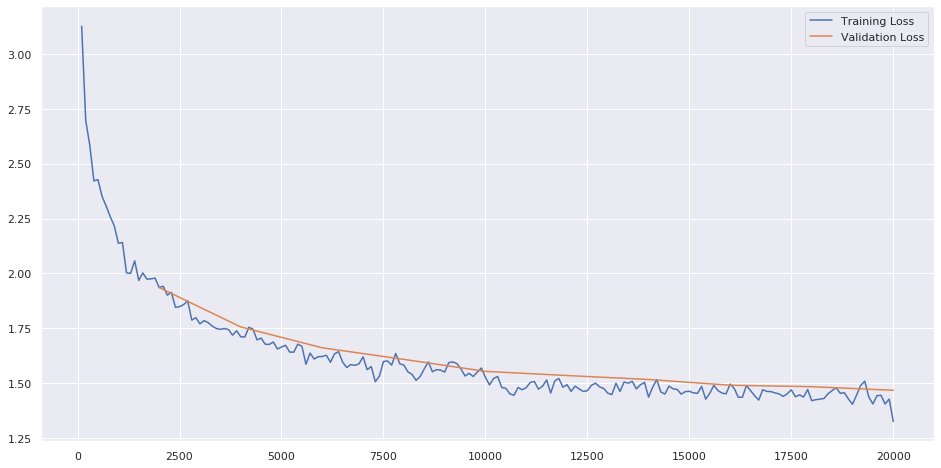

In [0]:
plt.plot(m['train_gs'], m['train_loss'], label='Training Loss')
plt.plot(m['valid_gs'], m['valid_loss'], label='Validation Loss')
plt.legend()
plt.show()

Now let's generate some sentences. First, we'll load the best saved model.

In [0]:
with open('model.pt', 'rb') as f:
  model.load_state_dict(torch.load(f))

Then we'll choose a seed and repeatedly sample from the Transformer. Remember, it will use its own outputs to generate new outputs since it is an autoregressive model. This means we pass in a seed, have it make a prediction, append that to the end of the seed, and repeat.

In [0]:
seed = 'The Milky Way '

In [0]:
generate(seed, max_len=100, sample=True, temperature=0.8)

"The Milky Way Twin each field in Space of State do not parallel in the Imperial Night's wide, in 199"